# CNN Modelling

This project is for creating a CNN classifier for gesture recognition

In [1]:
# Imports
from pathlib import Path
import os
import pickle
import time
from concurrent.futures import ThreadPoolExecutor, as_completed
from dataclasses import dataclass
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import resample, decimate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    ConfusionMatrixDisplay,
)

In [4]:
dataset = pd.read_pickle('dataset.pkl')

In [5]:
def reshape_windows_tensor_with_labels(data, y):
    """
    Converts data from:
        recordings x windows x channels x samples
    to:
        total_windows x channels x samples
    """
    X_windows = []
    y_windows = []
    data = data.to_list()
    y = y.to_list()
    for rec_idx, rec in enumerate(data):
        rec = np.asarray(rec)
        if rec.shape[0] == 0:
            continue

        for window in rec:
            X_windows.append(window)
            y_windows.append(y[rec_idx])

    return np.asarray(X_windows), np.asarray(y_windows)

(1038,)


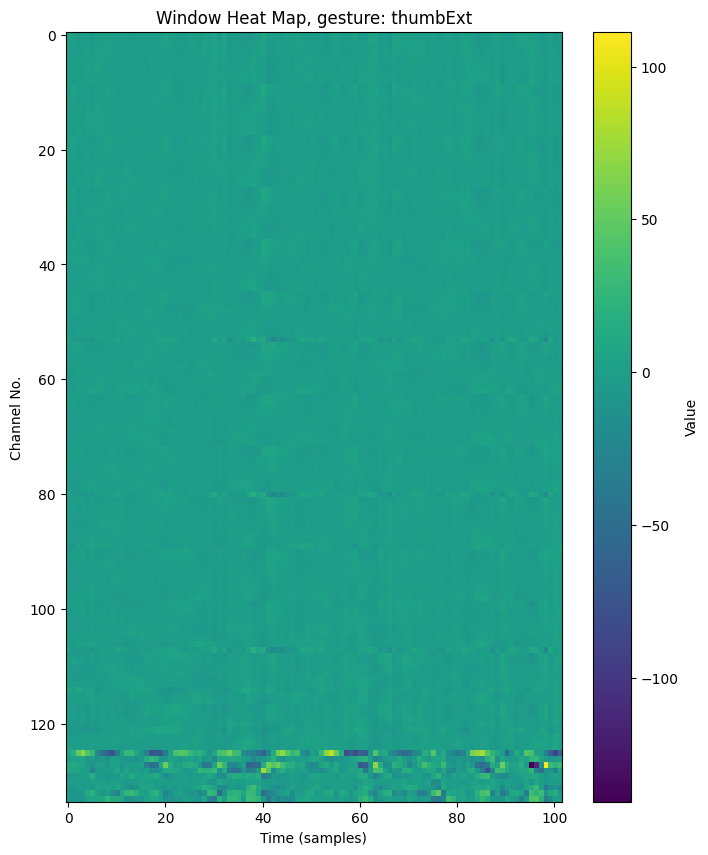

In [6]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)

print(X_train.shape)

X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
data = X_train[0]

plt.figure(figsize=(8, 10))
plt.imshow(data, aspect='auto', cmap='viridis')
plt.colorbar(label='Value')
plt.title(f'Window Heat Map, gesture: {y_train[0]}')
plt.xlabel('Time (samples)')
plt.ylabel('Channel No.')
plt.show()


In [7]:
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(42707, 134, 102)
(42707,)
(10229, 134, 102)
(10229,)


In [8]:
print("Per-trial containers:")
print("X_train:", type(X_train), getattr(X_train, "shape", None))
print("y_train:", type(y_train), getattr(y_train, "shape", None))

# Convert from per-trial -> per-window (ready for CNN)
X_train, X_test, y_train, y_test = train_test_split(dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42)
X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

print("\nPer-window tensors (CNN-ready):")
print("X_train shape:", X_train.shape)  # expected: (N_windows, C, T)
print("y_train shape:", y_train.shape)  # expected: (N_windows,)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Quick sanity check of channel/time dims
if X_train.ndim == 3:
    N, C, T = X_train.shape
    print(f"\nCNN expects [N, C, T] -> N={N}, C={C}, T={T}")
else:
    print("\nUnexpected X_train ndim:", X_train.ndim)

Per-trial containers:
X_train: <class 'numpy.ndarray'> (42707, 134, 102)
y_train: <class 'numpy.ndarray'> (42707,)

Per-window tensors (CNN-ready):
X_train shape: (42707, 134, 102)
y_train shape: (42707,)
X_test shape: (10229, 134, 102)
y_test shape: (10229,)

CNN expects [N, C, T] -> N=42707, C=134, T=102


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


In [14]:
# Split the data: 80% train_temp, 20% test (test set remains fixed)
train_temp_data, X_test, train_temp_labels, y_test = train_test_split(
    dataset['windows_raw'], dataset['movement'], test_size=0.2, random_state=42
)

# Process test set
X_test, y_test = reshape_windows_tensor_with_labels(X_test, y_test)

# Encode labels to integers
le = LabelEncoder()
le.fit(train_temp_labels)  # Fit on all training labels
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")
print("Classes:", list(le.classes_))

y_test_enc = le.transform(y_test).astype(np.int64, copy=False)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_enc, dtype=torch.long)

# Create test DataLoader
test_ds = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=(device.type == "cuda"))

print(f"Test set size: {len(X_test)}")
print(f"Training pool size: {len(train_temp_data)}")

Number of classes: 9
Classes: ['3digit', 'cilinder', 'fist', 'index_flex', 'middle_flex', 'pinch', 'point', 'thumbExt', 'thumbFlex']
Test set size: 10327
Training pool size: 1038


In [15]:
# DEFINE MODEL AND TRAINING FUNCTIONS

def make_deep_emg_cnn_model(num_classes: int):
    m = nn.Sequential(
        # Block 1
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 5), padding=(1, 2), bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 5), padding=(1, 2), bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.20),

        # Block 2
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.30),

        # Block 3
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), padding=1, bias=False),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(kernel_size=(2, 2)),
        nn.Dropout(0.40),

        # Global pooling -> avoids hard-coding Linear(in_features=...)
        nn.AdaptiveAvgPool2d((1, 1)),

        # Head
        nn.Flatten(),
        nn.Linear(128, num_classes),
    )
    return m

@torch.no_grad()
def evaluate(model, criterion, loader):
    model.eval()
    ys = []
    ps = []
    total_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        loss = criterion(logits, yb)
        total_loss += float(loss.item()) * int(yb.size(0))
        n += int(yb.size(0))
        pred = torch.argmax(logits, dim=1)
        ys.append(yb.cpu().numpy())
        ps.append(pred.cpu().numpy())
    y_true = np.concatenate(ys)
    y_pred = np.concatenate(ps)
    acc = accuracy_score(y_true, y_pred)
    return total_loss / max(n, 1), acc, y_true, y_pred

def train_one_epoch(model, criterion, optimizer, scaler, train_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    n = 0
    
    for xb, yb in train_loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast('cuda'):
            logits = model(xb)
            loss = criterion(logits, yb)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += float(loss.item()) * int(yb.size(0))
        pred = torch.argmax(logits, dim=1)
        correct += int((pred == yb).sum().item())
        n += int(yb.size(0))
    
    train_loss = running_loss / max(n, 1)
    train_acc = correct / max(n, 1)
    return train_loss, train_acc

def train_model(model, criterion, accuracy_fn, optimizer, train_loader, test_loader, num_epochs=30, batch_print=100):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    scaler = torch.GradScaler('cuda')
    
    for epoch in range(1, num_epochs + 1):
        train_loss, train_acc = train_one_epoch(model, criterion, optimizer, scaler, train_loader)
        val_loss, val_acc, _, _ = evaluate(model, criterion, test_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch}/{num_epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}")
    
    return history

def cross_entropy_accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == labels).sum().item()
    return correct / labels.size(0)

In [16]:
# Create and train multiple models with different train/val splits
history_array = []
models_array = []
criterion = nn.CrossEntropyLoss()

for run in range(10):
    print(f"\n{'='*60}")
    print(f"Training Run {run + 1}/10")
    print(f"{'='*60}")
    
    # Split training pool 50/50 into train and validation for this run
    X_train, X_val, y_train, y_val = train_test_split(train_temp_data, train_temp_labels, test_size=0.5, shuffle=True)
    
    # Process train and val sets
    X_train, y_train = reshape_windows_tensor_with_labels(X_train, y_train)
    X_val, y_val = reshape_windows_tensor_with_labels(X_val, y_val)
    
    y_train_enc = le.transform(y_train).astype(np.int64, copy=False)
    y_val_enc = le.transform(y_val).astype(np.int64, copy=False)
    
    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
    y_train_tensor = torch.tensor(y_train_enc, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val_enc, dtype=torch.long)
    
    # Create DataLoaders for this run
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    val_ds = TensorDataset(X_val_tensor, y_val_tensor)
    
    train_loader = DataLoader(train_ds, batch_size=256, shuffle=True, num_workers=2, pin_memory=(device.type == "cuda"))
    val_loader = DataLoader(val_ds, batch_size=256, shuffle=False, num_workers=2, pin_memory=(device.type == "cuda"))
    
    # Create fresh model for each run
    model = make_deep_emg_cnn_model(num_classes).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    history = train_model(
        model, 
        criterion, 
        cross_entropy_accuracy, 
        optimizer, 
        train_loader, 
        val_loader,
        num_epochs=30, 
        batch_print=100,
    )
    history_array.append(history)
    models_array.append(model)
    
print("\n" + "="*60)
print("All training runs completed!")
print("="*60)


Training Run 1/10
Epoch 1/30 - Train Loss: 1.7386, Train Acc: 0.37, Val Loss: 1.7980, Val Acc: 0.36
Epoch 2/30 - Train Loss: 1.3105, Train Acc: 0.53, Val Loss: 1.8936, Val Acc: 0.40
Epoch 3/30 - Train Loss: 1.0189, Train Acc: 0.65, Val Loss: 1.9050, Val Acc: 0.43
Epoch 4/30 - Train Loss: 0.8326, Train Acc: 0.72, Val Loss: 1.4034, Val Acc: 0.56
Epoch 5/30 - Train Loss: 0.6978, Train Acc: 0.77, Val Loss: 1.4024, Val Acc: 0.58
Epoch 6/30 - Train Loss: 0.5841, Train Acc: 0.81, Val Loss: 1.1206, Val Acc: 0.65
Epoch 7/30 - Train Loss: 0.5102, Train Acc: 0.83, Val Loss: 1.3307, Val Acc: 0.61
Epoch 8/30 - Train Loss: 0.4452, Train Acc: 0.85, Val Loss: 1.3847, Val Acc: 0.62
Epoch 9/30 - Train Loss: 0.3969, Train Acc: 0.87, Val Loss: 1.1887, Val Acc: 0.65
Epoch 10/30 - Train Loss: 0.3482, Train Acc: 0.89, Val Loss: 1.1963, Val Acc: 0.66
Epoch 11/30 - Train Loss: 0.3223, Train Acc: 0.89, Val Loss: 1.1455, Val Acc: 0.68
Epoch 12/30 - Train Loss: 0.2853, Train Acc: 0.91, Val Loss: 1.1670, Val Acc:

In [17]:
# SAVE THE HISTORY ARRAY TO A PICKLE
with open('cnn_training_history.pkl', 'wb') as f:
    pickle.dump(history_array, f)

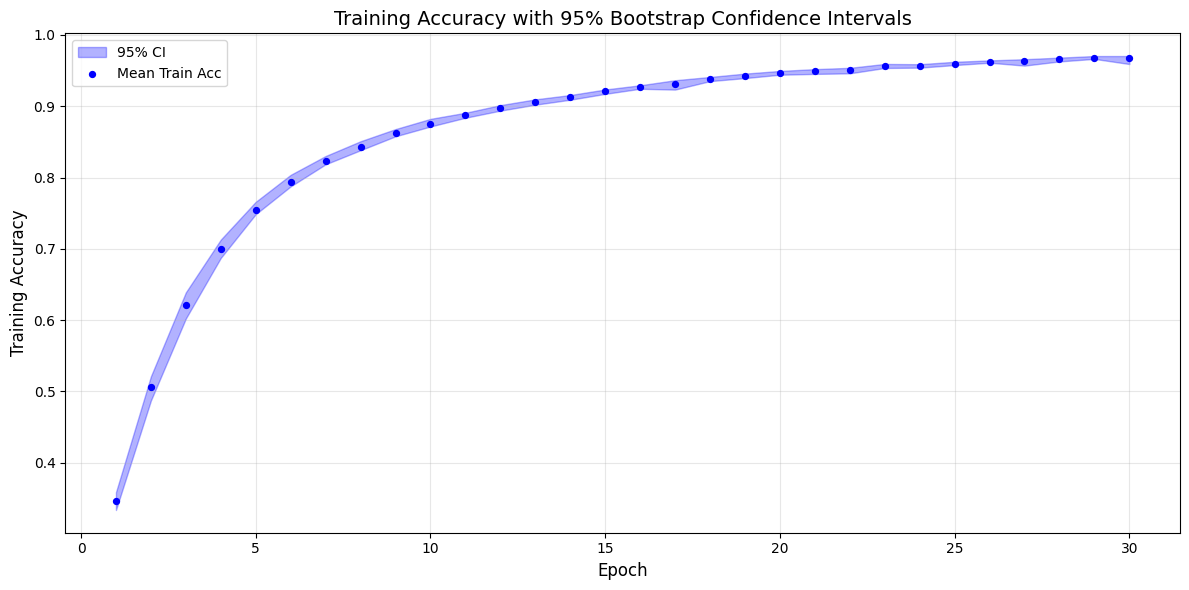

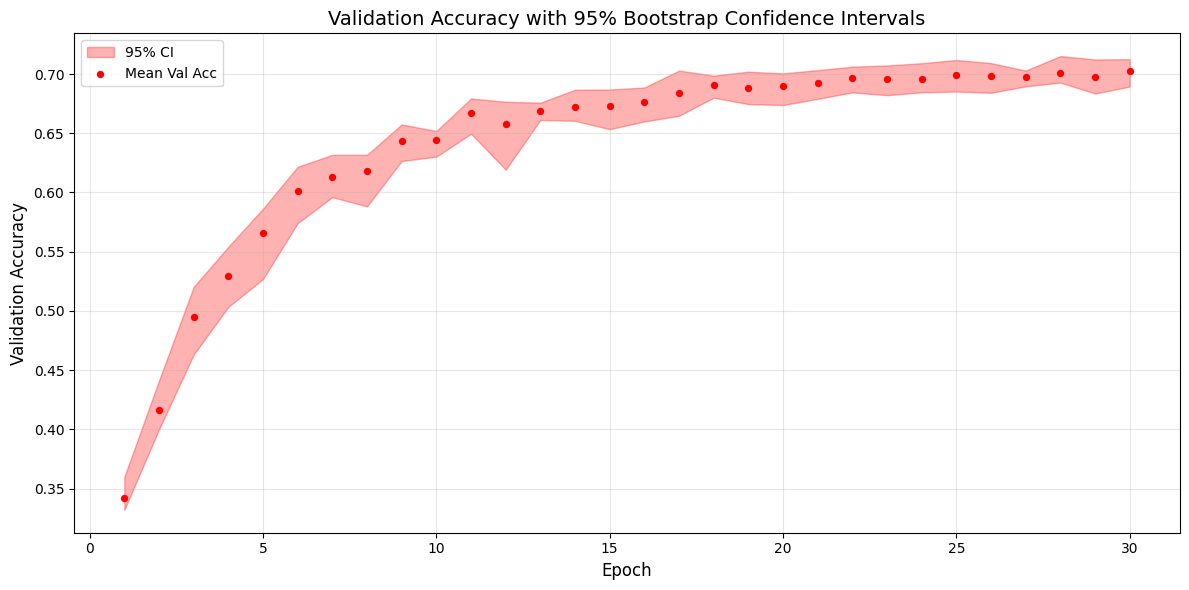


Summary (across runs):
Runs: 10
Epochs: 30
------------------------------------------------------------
Final Epoch Training Acc:   0.9673 [0.9592, 0.9704]
Final Epoch Validation Acc: 0.7030 [0.6894, 0.7126]



In [33]:
# Training + validation accuracy confidence intervals (no model selection, no evaluation)
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sp_stats

# history_array: list of dicts, each dict has keys: 'train_acc' and 'val_acc'
num_runs = len(history_array)
num_epochs = len(history_array[0]["train_acc"])

train_acc_mean, train_acc_ci_low, train_acc_ci_high = [], [], []
val_acc_mean, val_acc_ci_low, val_acc_ci_high = [], [], []

for epoch in range(num_epochs):
    train_values = np.array([hist["train_acc"][epoch] for hist in history_array], dtype=float)
    val_values = np.array([hist["val_acc"][epoch] for hist in history_array], dtype=float)

    train_ci_low, train_ci_high = sp_stats.bootstrap([train_values], np.mean, confidence_level=0.99).confidence_interval
    val_ci_low, val_ci_high = sp_stats.bootstrap([val_values], np.mean, confidence_level=0.99).confidence_interval

    train_acc_mean.append(float(train_values.mean()))
    train_acc_ci_low.append(float(train_ci_low))
    train_acc_ci_high.append(float(train_ci_high))

    val_acc_mean.append(float(val_values.mean()))
    val_acc_ci_low.append(float(val_ci_low))
    val_acc_ci_high.append(float(val_ci_high))

epochs = np.arange(1, num_epochs + 1)

# Plot training accuracy (means as dots ONLY, no connecting line)
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(epochs, train_acc_ci_low, train_acc_ci_high, alpha=0.3, color="blue", label="95% CI")
ax.scatter(epochs, train_acc_mean, c="blue", s=18, zorder=3, label="Mean Train Acc")  # dots only
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Training Accuracy", fontsize=12)
ax.set_title("Training Accuracy with 95% Bootstrap Confidence Intervals", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot validation accuracy (means as dots ONLY, no connecting line)
fig, ax = plt.subplots(figsize=(12, 6))
ax.fill_between(epochs, val_acc_ci_low, val_acc_ci_high, alpha=0.3, color="red", label="95% CI")
ax.scatter(epochs, val_acc_mean, c="red", s=18, zorder=3, label="Mean Val Acc")  # dots only
ax.set_xlabel("Epoch", fontsize=12)
ax.set_ylabel("Validation Accuracy", fontsize=12)
ax.set_title("Validation Accuracy with 95% Bootstrap Confidence Intervals", fontsize=14)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Summary (just the CI results; no model evaluation)
print(f"\n{'='*60}")
print("Summary (across runs):")
print(f"{'='*60}")
print(f"Runs: {num_runs}")
print(f"Epochs: {num_epochs}")
print(f"{'-'*60}")
print(f"Final Epoch Training Acc:   {train_acc_mean[-1]:.4f} [{train_acc_ci_low[-1]:.4f}, {train_acc_ci_high[-1]:.4f}]")
print(f"Final Epoch Validation Acc: {val_acc_mean[-1]:.4f} [{val_acc_ci_low[-1]:.4f}, {val_acc_ci_high[-1]:.4f}]")
print(f"{'='*60}\n")

This is not changing after 20 epochs. We will train a new model with the full training data and validate it from our testing

In [35]:
# Create fresh model for each run
X_train, y_train = reshape_windows_tensor_with_labels(train_temp_data, train_temp_labels)

X_train_t = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # (N,1,C,T)
y_train_t = torch.tensor(le.transform(y_train).astype(np.int64, copy=False), dtype=torch.long)

train_loader = DataLoader(
    TensorDataset(X_train_t, y_train_t),
    batch_size=256,
    shuffle=True,
    num_workers=2,
    pin_memory=(device.type == "cuda"),
)

model = make_deep_emg_cnn_model(num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = train_model(
    model, 
    criterion, 
    cross_entropy_accuracy, 
    optimizer, 
    train_loader, 
    test_loader,
    num_epochs=20, 
    batch_print=100,
)

Epoch 1/20 - Train Loss: 1.6366, Train Acc: 0.39, Val Loss: 3.1603, Val Acc: 0.38
Epoch 2/20 - Train Loss: 1.1180, Train Acc: 0.60, Val Loss: 1.3536, Val Acc: 0.53
Epoch 3/20 - Train Loss: 0.8733, Train Acc: 0.70, Val Loss: 5.1649, Val Acc: 0.46
Epoch 4/20 - Train Loss: 0.7293, Train Acc: 0.75, Val Loss: 1.2769, Val Acc: 0.62
Epoch 5/20 - Train Loss: 0.6511, Train Acc: 0.78, Val Loss: 1.3043, Val Acc: 0.61
Epoch 6/20 - Train Loss: 0.5868, Train Acc: 0.80, Val Loss: 0.7901, Val Acc: 0.74
Epoch 7/20 - Train Loss: 0.5250, Train Acc: 0.82, Val Loss: 0.8608, Val Acc: 0.73
Epoch 8/20 - Train Loss: 0.4738, Train Acc: 0.84, Val Loss: 0.8170, Val Acc: 0.75
Epoch 9/20 - Train Loss: 0.4410, Train Acc: 0.85, Val Loss: 0.7396, Val Acc: 0.75
Epoch 10/20 - Train Loss: 0.3932, Train Acc: 0.86, Val Loss: 0.7092, Val Acc: 0.77
Epoch 11/20 - Train Loss: 0.3375, Train Acc: 0.88, Val Loss: 0.7763, Val Acc: 0.75
Epoch 12/20 - Train Loss: 0.3239, Train Acc: 0.89, Val Loss: 0.8299, Val Acc: 0.75
Epoch 13/20 -

The final accuracy was 78% after 20 epochs

# **EVERYTHING BELOW RUN FOR 20 EPOCHS. TESTING BEING DONE**